In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline 


In [2]:
## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data.xlsx', sheetname= 'Data_Input', index_col=0)
ret_df_raw.describe()

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM,Cash
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.018989,0.035495,0.018274,0.027670,0.028452,0.017290,0.032061,0.008155
std,0.047757,0.070263,0.026435,0.076253,0.099660,0.091792,0.128686,0.006670
min,-0.333429,-0.214401,-0.083766,-0.219432,-0.261180,-0.211290,-0.275584,0.000000
25%,0.007742,0.004679,0.000719,-0.001749,-0.030336,-0.016548,-0.043980,0.000726
50%,0.018845,0.037985,0.017305,0.031222,0.037918,0.017968,0.038349,0.008214
75%,0.035783,0.069509,0.034229,0.070468,0.088459,0.066656,0.111489,0.013101
max,0.137135,0.264363,0.113356,0.212974,0.297346,0.258489,0.348433,0.023825


In [3]:
def cov2corr(cov, return_std=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr


In [4]:
ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_CORP',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
                   #'USGOVT10Y']]
ret_df_cov= ret_df.cov()
ret_df_corr= ret_df.corr()
N= ret_df.shape[1]
#ret_df

In [5]:
# period1_start= '1987-01-01'
# period1_end= '1999-07-01'
# period2_start= '2002-01-01'
# period2_end= '2008-01-01'
# period3_start= '2009-12-31'
# period3_end= '2017-12-31'

# ret_df1= ret_df[ np.logical_and( ret_df.index>= period1_start, ret_df.index<= period1_end) ]
# ret_df2= ret_df[ np.logical_and( ret_df.index>= period2_start, ret_df.index<= period2_end) ]
# ret_df3= ret_df[ np.logical_and( ret_df.index>= period3_start, ret_df.index<= period3_end) ]

In [6]:
## Ledoit Wolf shrunk cov matrix


from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_cov

LW_corr = pd.DataFrame(cov2corr(LW_cov))
LW_corr.index= ret_df_cov.index
LW_corr.columns= ret_df_cov.columns
LW_corr

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.296730,0.015200,0.307848,0.313075,0.260839,0.233716
US_PE,0.296730,1.000000,0.011812,0.692243,0.678817,0.611732,0.577800
US_CORP,0.015200,0.011812,1.000000,0.143748,0.079756,0.176276,0.118270
SP500,0.307848,0.692243,0.143748,1.000000,0.840865,0.771825,0.649903
Rusell2000,0.313075,0.678817,0.079756,0.840865,1.000000,0.704161,0.695298
EAFE,0.260839,0.611732,0.176276,0.771825,0.704161,1.000000,0.674103
EM,0.233716,0.577800,0.118270,0.649903,0.695298,0.674103,1.000000


In [7]:
np.sqrt(np.diagonal(np.matrix(LW_cov.values)))*2

array([ 0.09967199,  0.1412755 ,  0.06296121,  0.15254828,  0.1970037 ,
        0.18200475,  0.25263504])

In [8]:
## arithmatic avg ret to exponential avg ret 

ret_cov= np.diagonal(np.matrix(LW_cov.values))
coverter= np.array([ret_cov.tolist()]*ret_df.shape[0])* .5
ret_df_exp= ret_df- coverter


In [9]:
weight_eq= np.ones( (7,))*1.0/7
weight_peer= np.array( (0.14,0.29,0.05,0.24,0.03,0.21,0.05))
weight_peer= weight_peer/ np.sum(weight_peer)

In [10]:
## solve ERC weight 

def objective_func(w, sigma): 
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    
    return np.dot( C, C)


from scipy.optimize import minimize 

opt_res= minimize( objective_func, 
                 x0= weight_eq,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 bounds= [[0,None]]*7,
                 tol= 1e-16)

weight_erc = opt_res.x/ np.sum( opt_res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1281


C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


In [11]:
objective_func( weight_erc, LW_cov)

2.458695884580531e-23

In [12]:


portf_weight_1= pd.DataFrame( [weight_eq, weight_peer, weight_erc], 
                             index=['weight_eq', 'weight_peer', 'weight_erc'], 
                             columns= LW_cov. columns)
portf_weight_1

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,0.237624,0.029703,0.207921,0.049505
weight_erc,0.206808,0.105522,0.403146,0.085036,0.067863,0.074384,0.057241


In [13]:
## recover the implied expected ret based on shirinked cov matrix

rf= 179/10000
gamma= [ 1.5, 2, 2.5, 3, 3.5,4]
implied_ExpRet= {}

for w_name in portf_weight_1.index: 
    tmp_dic= {}
    for g in gamma:
        w= np.array(portf_weight_1.loc[w_name].tolist())
        tmp1= np.ones( ( N))* rf/4+ g*  np.dot( LW_cov, w)
        tmp2= np.ones( (N))*rf/4+ g* np.dot( ret_df_cov,w) 
        tmp_dic[str(g)+ '_shrunk']= tmp1
        tmp_dic[str(g)+'_unshrunk']= tmp2
    
    
    tmp= pd.DataFrame( tmp_dic, index= LW_cov.index)
    tmp= tmp- .5* np.array([np.diag(LW_cov).tolist()] *tmp.shape[1]).T
    implied_ExpRet[w_name]= tmp


In [14]:
(rf/4+ 3.5* np.dot( LW_cov, np.array( portf_weight_1.loc['weight_peer'])))*4

array([ 0.0359304 ,  0.06939446,  0.02178576,  0.07731827,  0.08946114,
        0.08627699,  0.09984899])

In [15]:
rf+ 3.5* np.dot(LW_cov*4, np.array(portf_weight_1.loc['weight_peer']))

array([ 0.0359304 ,  0.06939446,  0.02178576,  0.07731827,  0.08946114,
        0.08627699,  0.09984899])

In [16]:
portf_weight_1.loc['weight_peer'].values

array([ 0.13861386,  0.28712871,  0.04950495,  0.23762376,  0.02970297,
        0.20792079,  0.04950495])

In [17]:
LW_cov*4

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,0.009935,0.004178,0.000095,0.004681,0.006147,0.004732,0.005885
US_PE,0.004178,0.019959,0.000105,0.014919,0.018893,0.015729,0.020622
US_CORP,0.000095,0.000105,0.003964,0.001381,0.000989,0.002020,0.001881
SP500,0.004681,0.014919,0.001381,0.023271,0.025270,0.021429,0.025047
Rusell2000,0.006147,0.018893,0.000989,0.025270,0.038810,0.025248,0.034605
EAFE,0.004732,0.015729,0.002020,0.021429,0.025248,0.033126,0.030996
EM,0.005885,0.020622,0.001881,0.025047,0.034605,0.030996,0.063824


In [18]:
implied_ExpRet['weight_eq']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.057276,2.072893,2.566609,2.592638,2.311942,2.332765,3.075943,3.112383,2.821276,2.852511,3.330610,3.372256
US_PE,2.815033,2.906044,4.163680,4.315366,3.489357,3.610705,5.512328,5.724688,4.838004,5.020027,6.186652,6.429349
US_CORP,1.815416,1.798672,1.964498,1.936591,1.889957,1.867632,2.113579,2.074510,2.039038,2.005550,2.188120,2.143469
SP500,3.112107,3.230827,4.769211,4.967078,3.940659,4.098952,6.426316,6.703328,5.597764,5.835203,7.254868,7.571453
Rusell2000,3.062974,3.225280,5.205305,5.475816,4.134139,4.350548,7.347636,7.726352,6.276470,6.601084,8.418801,8.851619
EAFE,2.989717,3.130615,4.893718,5.128549,3.941717,4.129582,6.797720,7.126483,5.845719,6.127516,7.749721,8.125450
EM,2.517217,2.721740,5.129511,5.470382,3.823364,4.096061,7.741804,8.219024,6.435658,6.844703,9.047951,9.593346


In [19]:
implied_ExpRet['weight_erc']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,1.898968,1.891614,2.302763,2.290507,2.100865,2.091060,2.706558,2.689400,2.504660,2.489953,2.908456,2.888846
US_PE,1.979126,2.027954,2.770502,2.851883,2.374814,2.439919,3.561879,3.675812,3.166191,3.263847,3.957567,4.087776
US_CORP,1.902505,1.836069,2.109646,1.998919,2.006076,1.917494,2.316787,2.161769,2.213216,2.080344,2.420357,2.243193
SP500,2.099504,2.169781,3.081539,3.198667,2.590522,2.684224,4.063575,4.227553,3.572557,3.713110,4.554592,4.741997
Rusell2000,1.695274,1.791495,2.925805,3.086174,2.310539,2.438834,4.156336,4.380852,3.541071,3.733513,4.771602,5.028191
EAFE,1.817711,1.902867,2.940376,3.082303,2.379043,2.492585,4.063041,4.261739,3.501708,3.672021,4.624373,4.851456
EM,0.787103,0.906078,2.245987,2.444278,1.516545,1.675178,3.704871,3.982478,2.975429,3.213378,4.434313,4.751579


In [20]:
implied_ExpRet['weight_peer']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.066006,2.083041,2.581160,2.609552,2.323583,2.346296,3.096314,3.136063,2.838737,2.872807,3.353891,3.399318
US_PE,2.998967,3.070559,4.470237,4.589558,3.734602,3.830059,5.941507,6.108556,5.205872,5.349057,6.677142,6.868056
US_CORP,1.758327,1.757857,1.869349,1.868565,1.813838,1.813211,1.980370,1.979274,1.924860,1.923919,2.035881,2.034628
SP500,3.172948,3.275320,4.870613,5.041233,4.021781,4.158277,6.568278,6.807146,5.719445,5.924190,7.417110,7.690103
Rusell2000,2.916383,3.093781,4.960987,5.256650,3.938685,4.175216,7.005591,7.419520,5.983289,6.338085,8.027893,8.500954
EAFE,3.064156,3.195787,5.017784,5.237169,4.040970,4.216478,6.971412,7.278551,5.994598,6.257860,7.948227,8.299242
EM,2.110876,2.310758,4.452276,4.785412,3.281576,3.548085,6.793675,7.260066,5.622976,6.022739,7.964375,8.497393


In [21]:
## mean variance optimization, constuct efficient fronter 

CMA_ExpRet_geo= np.array( [700, 880, 275, 721, 806, 707, 803]) /10000 /4 #quarterly expected exponential ret 
LW_cov.index
CMA_ExpRet_arith= CMA_ExpRet_geo+ .5* np.diag(LW_cov)


In [22]:

def obj_func(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def obj_func_derivative( w, sigma): 
    return (np.dot( w, sigma))


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}



fronter1_w= {}
fronter1_vol= {}
fronter2_w= {}
fronter2_vol= {}

for target_ret in np.linspace(0.05, 0.09, 100 ): 
    cons_ineq4= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4
          )

    MV_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_w[target_ret]= MV_opt_1.x
    fronter1_vol[target_ret]= np.sqrt(MV_opt_1.fun*2) 
    
    fronter2_w[target_ret]= MV_opt_2.x
    fronter2_vol[target_ret]= np.sqrt(MV_opt_2.fun*2)
    
    
    
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.000809451547788455
            Iterations: 27
            Function evaluations: 220
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00035059108528499557
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477879257
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00035237865501287833
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477891686
            Iterations: 22
    

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]



            Current function value: 0.0008094515477883078
            Iterations: 56
            Function evaluations: 538
            Gradient evaluations: 52
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0003638268381389576
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477852782
            Iterations: 28
            Function evaluations: 230
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00036661854166150664
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477882762
            Iterations: 12
            Function evaluations: 44
            Gradie

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477882788
            Iterations: 85
            Function evaluations: 851
            Gradient evaluations: 81
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00046390346672969124
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477889351
            Iterations: 43
            Function evaluations: 355
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00047037699416601703
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008094515477885844
            Iterations: 39


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0006251715857493407
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0006832811918995212
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0006349922257095016
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0006956591352379392
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0006449798032578555
            Iterations: 25
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00120763692386158
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0010055028375607468
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012295975933989396
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00102037820265944
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012518447998127527
            Iterations: 25
        

(0.069797979797979803, 0.035636841209891246)
[  4.33268329e-01   3.00867620e-01   2.65864051e-01   1.86177842e-18
   0.00000000e+00   6.77626358e-19   0.00000000e+00]
(0.069393939393939397, 0.036674016450499357)
[  3.00000000e-01   3.00000000e-01   3.00000000e-01   8.97536693e-02
   0.00000000e+00   9.54097912e-18   1.02463307e-02]


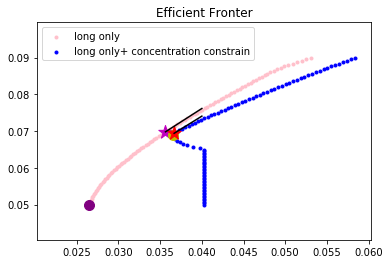

In [23]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
fig= plt.figure( )
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='purple', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='m', s=200)
plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 'k-')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'y', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='r', s=200)
plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 'k-')
plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [24]:
fronter1_vol

{0.050000000000000003: 0.026479844610004629,
 0.050404040404040409: 0.026547265584721841,
 0.050808080808080809: 0.026620803157425786,
 0.051212121212121216: 0.026700406789634378,
 0.051616161616161615: 0.026786022399422897,
 0.052020202020202022: 0.026877592535376114,
 0.052424242424242429: 0.026975056557455357,
 0.052828282828282828: 0.027078350823545611,
 0.053232323232323235: 0.027187408880454206,
 0.053636363636363642: 0.027302161658152194,
 0.054040404040404041: 0.027422537666081163,
 0.054444444444444448: 0.027548463190390376,
 0.054848484848484848: 0.027679862491021074,
 0.055252525252525254: 0.027816657997614781,
 0.055656565656565661: 0.027958770503289054,
 0.056060606060606061: 0.02810611935539651,
 0.056464646464646467: 0.028258622642458913,
 0.056868686868686874: 0.028416197376547013,
 0.057272727272727274: 0.028578759670457223,
 0.05767676767676768: 0.028746224909116606,
 0.05808080808080808: 0.028918507914727686,
 0.058484848484848487: 0.02909552310524265,
 0.05888888888

In [25]:
portf_weight_2= pd.DataFrame([efficient_portf1_w, efficient_portf2_w], 
                             index=['CMA_weight_longonly', 'CMA_weight_longonly_conc'], columns=LW_cov.columns)
pd.concat([portf_weight_1, portf_weight_2], axis=0)

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,1.428571e-01,0.142857,1.428571e-01,0.142857
weight_peer,0.138614,0.287129,0.049505,2.376238e-01,0.029703,2.079208e-01,0.049505
weight_erc,0.206808,0.105522,0.403146,8.503561e-02,0.067863,7.438370e-02,0.057241
CMA_weight_longonly,0.433268,0.300868,0.265864,1.861778e-18,0.000000,6.776264e-19,0.000000
CMA_weight_longonly_conc,0.300000,0.300000,0.300000,8.975367e-02,0.000000,9.540979e-18,0.010246


In [26]:
## risk adj return optimal long only portfolio with CMA expected ret


def obj_func_CMA(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMA( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMA_riskAdj_opt={}

for g in [2,2.5,3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMA, 
                    x0= weight_eq, 
                    args= [LW_cov, CMA_ExpRet_arith, g], 
                    jac= obj_func_derivative_CMA ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)
    
    CMA_riskAdj_opt[g]= MV_opt.x
    
CMA_riskAdj_portf_w= pd.DataFrame( CMA_riskAdj_opt, index=LW_cov.columns).T
CMA_riskAdj_portf_w.index= ['weight_CMA_MVO_gamma_'+str(x) for x in CMA_riskAdj_portf_w.index]
    


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019459632944501145
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01842792855832978
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01744948477477832
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01654968158369165
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.015731613699998894
            Iterations: 27
       

In [27]:
CMA_riskAdj_portf_w

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_CMA_MVO_gamma_2.0,0.3,0.3,8.225193e-17,9.429141e-17,0.180239,3.441316e-17,0.219761
weight_CMA_MVO_gamma_2.5,0.3,0.3,0.000000e+00,5.971859e-17,0.216760,0.000000e+00,0.183240
weight_CMA_MVO_gamma_3.0,0.3,0.3,0.000000e+00,7.642133e-02,0.161727,1.717747e-02,0.144674
weight_CMA_MVO_gamma_3.5,0.3,0.3,0.000000e+00,1.443261e-01,0.111692,2.801584e-02,0.115966
weight_CMA_MVO_gamma_4.0,0.3,0.3,5.234128e-02,1.417327e-01,0.085598,2.383323e-02,0.096495


In [28]:
## Introducing active management
# Apply active management to Equity (SP500, Rusell2000, EAFE and EM), 
# assuming IR of 1/3 and active alpha 1% and hence tracking error 3%, both annualized 


LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol), LW_cov), np.diag(1/LW_vol)), columns= LW_cov.columns, index=LW_cov.index)
LW_cov_active= pd.DataFrame(LW_cov+ np.diag( np.array([0, 0, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4])),
                           index= LW_cov.index,
                           columns= LW_cov.columns)
LW_vol_active= np.sqrt(np.diag(LW_cov_active))

CMA_ExpRet_active_geo= CMA_ExpRet_geo+ np.array([0,0,0.0050/4, 0.01/4, 0.01/4, 0.01/4, 0.01/4])
CMA_ExpRet_active_arith= CMA_ExpRet_arith+ np.array( [0,0,0.0050/4+ .5* 0.0004/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4 ])

LW_corr_active= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol_active), LW_cov_active), np.diag(1/LW_vol_active)), 
                            index= LW_cov_active.index,
                            columns= LW_cov_active.columns)


In [79]:
CMA_ExpRet_active_arith*4

array([ 0.07496725,  0.09797938,  0.03468206,  0.09418549,  0.11045523,
        0.09771286,  0.12266223])

In [29]:
## Fronter Construction with active management



fronter1_active_w= {}
fronter1_active_vol= {}
fronter2_active_w= {}
fronter2_active_vol= {}

for target_ret in np.linspace(0.065, 0.1, 100 ): 
    cons_ineq4_active= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_active_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_active_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4_active
          )

    MV_active_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_active_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_active_w[target_ret]= MV_active_opt_1.x
    fronter1_active_vol[target_ret]= np.sqrt(MV_active_opt_1.fun*2) 
    
    fronter2_active_w[target_ret]= MV_active_opt_2.x
    fronter2_active_vol[target_ret]= np.sqrt(MV_active_opt_2.fun*2)
    
    
    


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00083082654778813
            Iterations: 19
            Function evaluations: 145
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0005080198828444763
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008308265477880328
            Iterations: 73
            Function evaluations: 726
            Gradient evaluations: 69
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0005142246725365556
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008308265477882536
            Iterations: 11
    

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0008308265477881874
            Iterations: 101
            Function evaluations: 1039
            Gradient evaluations: 98
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0005270839538023322
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008308265477876277
            Iterations: 10
            Function evaluations: 36
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0005337384453760296
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008308265477883065
            Iterations: 34
            Fun

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0007607492902324927
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0007281643246883209
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0007724492551822416
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0007384164314139666
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0007843444409433316
            Iterations: 27
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0009882837811631044
            Iterations: 34
            Function evaluations: 35
            Gradient evaluations: 34
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0010792393493463538
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0010018262659069522
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0010954293929569788
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0010155181251813243
            Iterations: 43
    

            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014401321757139408
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0013181397014490894
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014602266355514181
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001338787957432986
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Ex

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.002120218295066851
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0020889293895737164
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021607219869971593
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021284225236259885
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0022019716910801294
            Iterations: 23
     

(0.069797979797979803, 0.035636841209891246)
[  4.33268329e-01   3.00867620e-01   2.65864051e-01   1.86177842e-18
   0.00000000e+00   6.77626358e-19   0.00000000e+00]
(0.069393939393939397, 0.036674016450499357)
[  3.00000000e-01   3.00000000e-01   3.00000000e-01   8.97536693e-02
   0.00000000e+00   9.54097912e-18   1.02463307e-02]
(0.069949494949494956, 0.034886326709216181)
[  4.06279338e-01   2.51915192e-01   2.98780119e-01   2.91655969e-02
   9.82558219e-20   1.47722546e-18   1.38597546e-02]
(0.072070707070707077, 0.037019954195182295)
[  3.00000000e-01   3.00000000e-01   3.00000000e-01   8.33914428e-02
   4.86925610e-19   4.38519375e-03   1.22233635e-02]


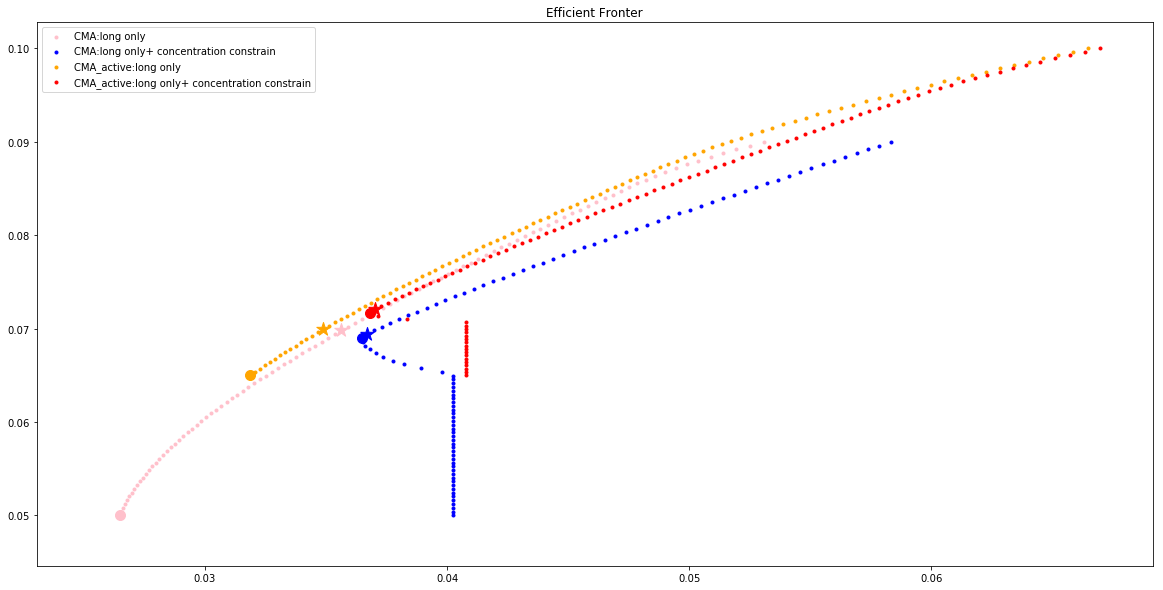

In [30]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

fronter_active_1= list( fronter1_active_vol.items())
fronter_active_1.sort(key= lambda x: x[1])
minvar_active_portf1= fronter_active_1[0]
minvar_active_portf1_w= fronter1_active_w[minvar_active_portf1[0]]
fronter_active_1.sort(key= lambda x: (x[0]-rf)/x[1], reverse =True)
efficient_portf1_active= fronter_active_1[0]
efficient_portf1_active_w= fronter1_active_w[efficient_portf1_active[0]]


fronter_active_2= list( fronter2_active_vol.items())
fronter_active_2.sort( key= lambda x: x[1])
minvar_active_portf2= fronter_active_2[0]
minvar_active_portf2_w= fronter2_active_w[ minvar_active_portf2[0]]
fronter_active_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2_active= fronter_active_2[0]
efficient_portf2_active_w= fronter2_active_w[efficient_portf2_active[0]]


fig= plt.figure(figsize= (20,10))

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'CMA:long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='pink', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='pink', s=200)
# plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 
#          linestyle='-', c='pink')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'CMA:long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'blue', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='blue', s=200)
# plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 
#          linestyle= '-', c= 'blue')


[tmp_ret, tmp_vol]= zip( * list( fronter1_active_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'orange' , label= 'CMA_active:long only')
plt.scatter(x= minvar_active_portf1[1], y= minvar_active_portf1[0], marker= 'o', c='orange', s= 100 )
plt.scatter(x= efficient_portf1_active[1], y = efficient_portf1_active[0], marker= '*', c='orange', s=200)
# plt.plot( [0.04, efficient_portf1_active[1]], [ (efficient_portf1_active[0]-rf)/efficient_portf1_active[1]* 0.04+rf, efficient_portf1_active[0]], 
#          linestyle='-', c='orange')

[tmp_ret, tmp_vol]= zip(* list(fronter2_active_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='red', label= 'CMA_active:long only+ concentration constrain')
plt.scatter( x= minvar_active_portf2[1], y=minvar_active_portf2[0], marker= 'o', c= 'red', s=100)
plt.scatter(x= efficient_portf2_active[1], y = efficient_portf2_active[0], marker= '*', c='red', s=200)
# plt.plot( [0.04, efficient_portf2_active[1]], [ (efficient_portf2_active[0]-rf)/efficient_portf2_active[1]* 0.04+rf, efficient_portf2_active[0]], 
#          linestyle= '-', c='red')




plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)
print(efficient_portf1_active)
print(efficient_portf1_active_w)
print(efficient_portf2_active)
print(efficient_portf2_active_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [31]:
portf_weight_3= pd.DataFrame( [efficient_portf1_active_w, efficient_portf2_active_w],
                            index= ['CMA_active_weight_longonly', 'CMA_active_weight_longonly_conc'], 
                            columns= LW_cov.columns)

pd.concat([portf_weight_1, portf_weight_2, portf_weight_3], axis=0)

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
weight_peer,0.138614,0.287129,0.049505,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
weight_erc,0.206808,0.105522,0.403146,8.503561e-02,6.786336e-02,7.438370e-02,0.057241
CMA_weight_longonly,0.433268,0.300868,0.265864,1.861778e-18,0.000000e+00,6.776264e-19,0.000000
CMA_weight_longonly_conc,0.300000,0.300000,0.300000,8.975367e-02,0.000000e+00,9.540979e-18,0.010246
CMA_active_weight_longonly,0.406279,0.251915,0.298780,2.916560e-02,9.825582e-20,1.477225e-18,0.013860
CMA_active_weight_longonly_conc,0.300000,0.300000,0.300000,8.339144e-02,4.869256e-19,4.385194e-03,0.012223


In [32]:
## Risk adj return utility constrained optimal with active management 




def obj_func_CMAactive(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMAactive( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMAactive_riskAdj_opt={}
CMAactive_riskAdj_opt2={}
for g in [3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)

    MV_opt2= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,None]]* N,
                    tol= 1e-12)
    
    CMAactive_riskAdj_opt[g]= MV_opt.x
    CMAactive_riskAdj_opt2[g]= MV_opt2.x
    
CMAactive_riskAdj_portf_w= pd.DataFrame( CMAactive_riskAdj_opt, index=LW_cov_active.columns).T
CMAactive_riskAdj_portf_w.index= ['weight_CMAactive_MVO_gamma_'+str(x) for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w2= pd.DataFrame( CMAactive_riskAdj_opt2, index= LW_cov_active.columns).T
CMAactive_riskAdj_portf_w2.index= ['weight_CMAactive_MVO_gamma_'+str(x)+'uncons' for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018476834312564236
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01866009072912418
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017576302729148934
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01788517868153018
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.016721481313474246
            Iterations: 22
      

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_CMAactive_MVO_gamma_3.0,0.3,0.3,0.000000,0.078448,0.155829,0.022550,0.143174
weight_CMAactive_MVO_gamma_3.5,0.3,0.3,0.000000,0.136798,0.113239,0.035310,0.114653
weight_CMAactive_MVO_gamma_4.0,0.3,0.3,0.002562,0.178221,0.081660,0.044196,0.093362


In [33]:
  #pd.DataFrame(CMAactive_riskAdj_opt[2],)

In [34]:
portf_weight= pd.concat( [portf_weight_1, 
                          portf_weight_2, 
                          CMA_riskAdj_portf_w.iloc[ -3:] ,
                          portf_weight_3, 
                          CMAactive_riskAdj_portf_w,
                         CMAactive_riskAdj_portf_w2], axis= 0 )
portf_weight.index= ['w_eq', # equal weight 
                    'w_peer', # peer weight
                    'w_erc', # equal risk contribution weight 
                    'w_MVO_1', # mean-variance optimal weight with long only constrain
                    'w_MVO_2', # mean-variance optimal weight with long only+ concentration constrain
                    'w_RUO_3', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 3 
                    'w_RUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, given risk aversion 3.5
                    'w_RUO_4', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 4
                    'w_aMVO_1', # mean-variance optimal weight with long only constrain, and active management 
                    'w_aMVO_2', # mean-variance optimal weight with long only+ concentration constrain, and active management 
                    'w_aRUO_3', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3 
                    'w_aRUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3.5 
                    'w_aRUO_4', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 4
                    'w_aRUO_3unc',
                    'w_aRUO_3.5unc',
                    'w_aRUO_4unc'] 
portf_weight

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.206808,0.105522,4.031462e-01,8.503561e-02,6.786336e-02,7.438370e-02,0.057241
w_MVO_1,0.433268,0.300868,2.658641e-01,1.861778e-18,0.000000e+00,6.776264e-19,0.000000
w_MVO_2,0.300000,0.300000,3.000000e-01,8.975367e-02,0.000000e+00,9.540979e-18,0.010246
w_RUO_3,0.300000,0.300000,0.000000e+00,7.642133e-02,1.617271e-01,1.717747e-02,0.144674
w_RUO_3.5,0.300000,0.300000,0.000000e+00,1.443261e-01,1.116916e-01,2.801584e-02,0.115966
w_RUO_4,0.300000,0.300000,5.234128e-02,1.417327e-01,8.559820e-02,2.383323e-02,0.096495
w_aMVO_1,0.406279,0.251915,2.987801e-01,2.916560e-02,9.825582e-20,1.477225e-18,0.013860
w_aMVO_2,0.300000,0.300000,3.000000e-01,8.339144e-02,4.869256e-19,4.385194e-03,0.012223


In [35]:
ExpRet=  pd.concat([implied_ExpRet['weight_eq'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T, 
                   implied_ExpRet['weight_peer'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   implied_ExpRet['weight_erc'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   pd.DataFrame([CMA_ExpRet_geo,CMA_ExpRet_active_geo], columns= LW_cov.columns)], 
                   axis=0)* 400
ExpRet.index= ['iRet_eq_3', # implied expected return from equal weight with risk aversion 3
               'iRet_eq_3.5', # implied expected return from equal weight with risk aversion 3.5
               'iRet_eq_4',
               'iRet_peer_3', # implied expected return from peer weight with risk aversion 3
               'iRet_peer_3.5', # implied expected return from peer weight with risk aversion 3.5
               'iRet_peer_4',
               'iRet_erc_3', # implied expected return from equal risk contribution weight with risk aversion 3
               'iRet_erc_3.5',# implied expected return from equal risk contribution weight with risk aversion 3.5
               'iRet_erc_4',
               'CMA', # CMA expected return 
               'CMA_active' # CMA expected return, and active management
              ]

ExpRet # annualized expected ret in percentage 

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.821276,4.838004,2.039038,5.597764,6.276470,5.845719,6.435658
iRet_eq_3.5,3.075943,5.512328,2.113579,6.426316,7.347636,6.797720,7.741804
iRet_eq_4,3.330610,6.186652,2.188120,7.254868,8.418801,7.749721,9.047951
iRet_peer_3,2.838737,5.205872,1.924860,5.719445,5.983289,5.994598,5.622976
iRet_peer_3.5,3.096314,5.941507,1.980370,6.568278,7.005591,6.971412,6.793675
iRet_peer_4,3.353891,6.677142,2.035881,7.417110,8.027893,7.948227,7.964375
iRet_erc_3,2.504660,3.166191,2.213216,3.572557,3.541071,3.501708,2.975429
iRet_erc_3.5,2.706558,3.561879,2.316787,4.063575,4.156336,4.063041,3.704871
iRet_erc_4,2.908456,3.957567,2.420357,4.554592,4.771602,4.624373,4.434313
CMA,7.000000,8.800000,2.750000,7.210000,8.060000,7.070000,8.030000


### Black-Litterman Framework 

Construct BL framework to incorporate benchmark(prior) and views(observations) and produce a reasonable distribution of expected return (posterior). 
Apply mean-variance optimization based on posterior to achieve optimal allocation. 

#### Benckmark/Equilibrium Portfolio

Set the benchmark as peer holding `w_peer`, then `iRet_peer_3.5` is the implied equilibrium\benchmark expected return, given risk aversion factor 3.5.

#### The prior confidence  $\tau$

Follow BL's initial setting, $\tau = 0.05$

#### Views

`CMA_active` is the subjective view to expected return of each asset. The confidence is proportional to view portfolio (prior) variance with multiplier $\tau$





#### As summary, input: 

$\tau$

prior expected ret distribution, assuming normal, so the prior mean and variance 

views, the view portfolio weight, asserted expected ret, and view confidence. 

#### output: 

the posterior distribution, mean and variance of post expected return. 

In [36]:

## prepare input

tau = 5e-2
prior_cov= LW_cov* tau
prior_cov_inv= np.linalg.inv(prior_cov)
prior_mean= np.array(ExpRet.loc['iRet_peer_3.5'].tolist())/100/4+ 0.5* np.diag(LW_cov)



# CMA_ExpRet_active_arith 
# is the asserted expected return 
view_w= np.identity(N)
view_ExpRet= CMA_ExpRet_active_arith
view_cov= ( (LW_cov_active)* tau * 2)
view_cov_inv= np.linalg.inv( view_cov)

##  output: post 

A= prior_cov_inv
B= np.dot( np.dot(view_w.T, view_cov_inv), view_w)
C= np.dot(prior_cov_inv, prior_mean)
D= np.dot(np.dot(view_w.T, view_cov_inv), view_ExpRet)

post_mean_arith= pd.DataFrame( np.dot(np.linalg.inv( A+B), C+D), index=LW_cov.index, columns= ['post_ExpRet']) .T
post_cov= pd.DataFrame( np.linalg.inv( prior_cov_inv+ np.dot( np.dot( view_w.T, view_cov_inv), view_w)), index= LW_cov.index, columns= LW_cov.columns)
post_mean_geo= post_mean_arith- .5* np.diag( LW_cov_active)

In [37]:
pd.concat([ ExpRet.loc[['iRet_peer_3.5', 'CMA_active']], 
          post_mean_geo*400], axis=0)


,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
iRet_peer_3.5,3.096314,5.941507,1.980370,6.568278,7.005591,6.971412,6.793675
CMA_active,7.000000,8.800000,3.250000,8.210000,9.060000,8.070000,9.030000
post_ExpRet,4.397543,6.894338,2.301006,7.091954,7.665603,7.323758,7.508906


In [85]:
tau

0.05

In [82]:
A

array([[  9088.3702936 ,   -847.34998346,    185.25033372,   -541.65578783,
          -655.38121862,   -101.83760737,     47.66831051],
       [  -847.34998346,   8704.11225173,   1748.41244825,  -2634.43580476,
         -1351.94043629,   -789.08064982,   -635.74172855],
       [   185.25033372,   1748.41244825,  21404.42466291,  -1846.35602555,
          1000.44140031,  -1403.09965176,   -349.37005635],
       [  -541.65578783,  -2634.43580476,  -1846.35602555,  15966.61952323,
         -6466.86427375,  -4162.75136629,    217.67166993],
       [  -655.38121862,  -1351.94043629,   1000.44140031,  -6466.86427375,
          8465.89780981,   -205.12769193,  -1484.94611188],
       [  -101.83760737,   -789.08064982,  -1403.09965176,  -4162.75136629,
          -205.12769193,   7002.45278183,  -1350.16442426],
       [    47.66831051,   -635.74172855,   -349.37005635,    217.67166993,
         -1484.94611188,  -1350.16442426,   2840.15218947]])

In [40]:
view_ExpRet*4

array([ 0.07496725,  0.09797938,  0.03468206,  0.09418549,  0.11045523,
        0.09771286,  0.12266223])

In [81]:
LW_cov_active*4

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,0.009935,0.004178,0.000095,0.004681,0.006147,0.004732,0.005885
US_PE,0.004178,0.019959,0.000105,0.014919,0.018893,0.015729,0.020622
US_CORP,0.000095,0.000105,0.004864,0.001381,0.000989,0.002020,0.001881
SP500,0.004681,0.014919,0.001381,0.024171,0.025270,0.021429,0.025047
Rusell2000,0.006147,0.018893,0.000989,0.025270,0.039710,0.025248,0.034605
EAFE,0.004732,0.015729,0.002020,0.021429,0.025248,0.034026,0.030996
EM,0.005885,0.020622,0.001881,0.025047,0.034605,0.030996,0.064724


In [41]:
## MVO based over post expected mean and variance


MV_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                bounds= [[0,0.3]]* (N),
                tol= 1e-120)

MV_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.011985032629645936
            Iterations: 42
            Function evaluations: 82
            Gradient evaluations: 42


array([ 0.3       ,  0.3       ,  0.02457029,  0.16224048,  0.03151772,
        0.12676491,  0.05490661])

In [42]:
MV_unc_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[0,None]]* N,
                tol= 1e-120)

MV_unc_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01199430907624148
            Iterations: 45
            Function evaluations: 62
            Gradient evaluations: 45


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


array([  3.24234315e-01,   3.25842265e-01,   1.38744651e-24,
         1.48481806e-01,   2.39987935e-02,   1.23909207e-01,
         5.35336133e-02])

In [43]:
portf_weight_final= pd.concat( [portf_weight,
                         pd.DataFrame( [MV_opt.x, MV_unc_opt.x], columns= portf_weight.columns, index= ['w_BL', 'w_BL_unc'])], axis=0)
portf_weight_final

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.206808,0.105522,4.031462e-01,8.503561e-02,6.786336e-02,7.438370e-02,0.057241
w_MVO_1,0.433268,0.300868,2.658641e-01,1.861778e-18,0.000000e+00,6.776264e-19,0.000000
w_MVO_2,0.300000,0.300000,3.000000e-01,8.975367e-02,0.000000e+00,9.540979e-18,0.010246
w_RUO_3,0.300000,0.300000,0.000000e+00,7.642133e-02,1.617271e-01,1.717747e-02,0.144674
w_RUO_3.5,0.300000,0.300000,0.000000e+00,1.443261e-01,1.116916e-01,2.801584e-02,0.115966
w_RUO_4,0.300000,0.300000,5.234128e-02,1.417327e-01,8.559820e-02,2.383323e-02,0.096495
w_aMVO_1,0.406279,0.251915,2.987801e-01,2.916560e-02,9.825582e-20,1.477225e-18,0.013860
w_aMVO_2,0.300000,0.300000,3.000000e-01,8.339144e-02,4.869256e-19,4.385194e-03,0.012223


In [44]:
portf_weight_final.loc[['w_peer', 'w_aRUO_3.5', 'w_BL', 'w_BL_unc']]

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
w_peer,0.138614,0.287129,4.950495e-02,0.237624,0.029703,0.207921,0.049505
w_aRUO_3.5,0.300000,0.300000,0.000000e+00,0.136798,0.113239,0.035310,0.114653
w_BL,0.300000,0.300000,2.457029e-02,0.162240,0.031518,0.126765,0.054907
w_BL_unc,0.324234,0.325842,1.387447e-24,0.148482,0.023999,0.123909,0.053534


In [45]:
ExpRet_final= pd.concat([ExpRet, 
                        post_mean_geo*400], axis=0)
ExpRet_final

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.821276,4.838004,2.039038,5.597764,6.276470,5.845719,6.435658
iRet_eq_3.5,3.075943,5.512328,2.113579,6.426316,7.347636,6.797720,7.741804
iRet_eq_4,3.330610,6.186652,2.188120,7.254868,8.418801,7.749721,9.047951
iRet_peer_3,2.838737,5.205872,1.924860,5.719445,5.983289,5.994598,5.622976
iRet_peer_3.5,3.096314,5.941507,1.980370,6.568278,7.005591,6.971412,6.793675
iRet_peer_4,3.353891,6.677142,2.035881,7.417110,8.027893,7.948227,7.964375
iRet_erc_3,2.504660,3.166191,2.213216,3.572557,3.541071,3.501708,2.975429
iRet_erc_3.5,2.706558,3.561879,2.316787,4.063575,4.156336,4.063041,3.704871
iRet_erc_4,2.908456,3.957567,2.420357,4.554592,4.771602,4.624373,4.434313
CMA,7.000000,8.800000,2.750000,7.210000,8.060000,7.070000,8.030000


In [46]:
pd.DataFrame(np.sqrt(np.diag( LW_cov))).T*2

,0,1,2,3,4,5,6
0,0.099672,0.141276,0.062961,0.152548,0.197004,0.182005,0.252635


In [47]:
LW_corr

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.296730,0.015200,0.307848,0.313075,0.260839,0.233716
US_PE,0.296730,1.000000,0.011812,0.692243,0.678817,0.611732,0.577800
US_CORP,0.015200,0.011812,1.000000,0.143748,0.079756,0.176276,0.118270
SP500,0.307848,0.692243,0.143748,1.000000,0.840865,0.771825,0.649903
Rusell2000,0.313075,0.678817,0.079756,0.840865,1.000000,0.704161,0.695298
EAFE,0.260839,0.611732,0.176276,0.771825,0.704161,1.000000,0.674103
EM,0.233716,0.577800,0.118270,0.649903,0.695298,0.674103,1.000000


In [48]:
LW_corr_active

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.296730,0.013722,0.302062,0.309507,0.257366,0.232085
US_PE,0.296730,1.000000,0.010663,0.679233,0.671080,0.603588,0.573769
US_CORP,0.013722,0.010663,1.000000,0.127331,0.071180,0.157016,0.106024
SP500,0.302062,0.679233,0.127331,1.000000,0.815659,0.747236,0.633240
Rusell2000,0.309507,0.671080,0.071180,0.815659,1.000000,0.686868,0.682578
EAFE,0.257366,0.603588,0.157016,0.747236,0.686868,1.000000,0.660487
EM,0.232085,0.573769,0.106024,0.633240,0.682578,0.660487,1.000000


In [49]:
pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(portf_weight.iloc[0:3], LW_cov), portf_weight.iloc[0:3].T)))*2).T

,0,1,2
0,0.121437,0.121885,0.076456


In [50]:
ExpRet_final

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.821276,4.838004,2.039038,5.597764,6.276470,5.845719,6.435658
iRet_eq_3.5,3.075943,5.512328,2.113579,6.426316,7.347636,6.797720,7.741804
iRet_eq_4,3.330610,6.186652,2.188120,7.254868,8.418801,7.749721,9.047951
iRet_peer_3,2.838737,5.205872,1.924860,5.719445,5.983289,5.994598,5.622976
iRet_peer_3.5,3.096314,5.941507,1.980370,6.568278,7.005591,6.971412,6.793675
iRet_peer_4,3.353891,6.677142,2.035881,7.417110,8.027893,7.948227,7.964375
iRet_erc_3,2.504660,3.166191,2.213216,3.572557,3.541071,3.501708,2.975429
iRet_erc_3.5,2.706558,3.561879,2.316787,4.063575,4.156336,4.063041,3.704871
iRet_erc_4,2.908456,3.957567,2.420357,4.554592,4.771602,4.624373,4.434313
CMA,7.000000,8.800000,2.750000,7.210000,8.060000,7.070000,8.030000


In [51]:
pd.DataFrame(np.dot(LW_cov, portf_weight.loc[['w_eq', 'w_peer', 'w_erc']].T), index=LW_cov.index, columns= ['ew', 'peer', 'erc'])*4

,ew,peer,erc
US_RE,0.005093,0.005152,0.004038
US_PE,0.013486,0.014713,0.007914
US_CORP,0.001491,0.001110,0.002071
SP500,0.016571,0.016977,0.009820
Rusell2000,0.021423,0.020446,0.012305
EAFE,0.019040,0.019536,0.011227
EM,0.026123,0.023414,0.014589


In [52]:
tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5unc', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100
tmp_vol= np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2

pd.DataFrame(tmp_ret).T

,0,1
0,0.081061,0.082093


In [53]:
pd.DataFrame(tmp_vol).T

,0,1
0,0.108702,0.118285


In [54]:
pd.DataFrame(view_w)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
pd.DataFrame(ExpRet_final.loc['CMA_active'])

,CMA_active
US_RE,7.00
US_PE,8.80
US_CORP,3.25
SP500,8.21
Rusell2000,9.06
EAFE,8.07
EM,9.03


In [56]:
bl_w= portf_weight_final.loc[['w_BL_unc', 'w_BL']]
bl_ret= ExpRet_final.loc['post_ExpRet'].values/100
bl_w.T

,w_BL_unc,w_BL
US_RE,3.242343e-01,0.300000
US_PE,3.258423e-01,0.300000
US_CORP,1.387447e-24,0.024570
SP500,1.484818e-01,0.162240
Rusell2000,2.399879e-02,0.031518
EAFE,1.239092e-01,0.126765
EM,5.353361e-02,0.054907


In [57]:
tmp_ret_BL=pd.DataFrame(np.dot(bl_w, bl_ret)).T
tmp_vol_BL= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(bl_w, LW_cov_active+ post_cov), bl_w.T)))*2).T

pd.concat( [tmp_ret_BL, tmp_vol_BL], axis=0)

,0,1
0,0.062188,0.061770
0,0.112214,0.111565


In [58]:
LW_cov_active

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,0.002484,0.001045,0.000024,0.001170,0.001537,0.001183,0.001471
US_PE,0.001045,0.004990,0.000026,0.003730,0.004723,0.003932,0.005156
US_CORP,0.000024,0.000026,0.001216,0.000345,0.000247,0.000505,0.000470
SP500,0.001170,0.003730,0.000345,0.006043,0.006318,0.005357,0.006262
Rusell2000,0.001537,0.004723,0.000247,0.006318,0.009928,0.006312,0.008651
EAFE,0.001183,0.003932,0.000505,0.005357,0.006312,0.008506,0.007749
EM,0.001471,0.005156,0.000470,0.006262,0.008651,0.007749,0.016181


In [59]:
LW_cov_active+ post_cov

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,0.002566,0.001079,0.000025,0.001209,0.001588,0.001222,0.001520
US_PE,0.001079,0.005156,0.000027,0.003854,0.004881,0.004063,0.005327
US_CORP,0.000025,0.000027,0.001251,0.000357,0.000256,0.000522,0.000486
SP500,0.001209,0.003854,0.000357,0.006239,0.006528,0.005536,0.006470
Rusell2000,0.001588,0.004881,0.000256,0.006528,0.010253,0.006522,0.008940
EAFE,0.001222,0.004063,0.000522,0.005536,0.006522,0.008785,0.008007
EM,0.001520,0.005327,0.000486,0.006470,0.008940,0.008007,0.016715


In [60]:

tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100


tmp_vol= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2).T

pd.DataFrame(tmp_ret).T



,0,1
0,0.082093,0.082093


In [61]:
pd.DataFrame(tmp_vol).T

,0
0,0.118285
1,0.118285


### Bechmark+ active 

Benchmark = Peer

Active= Max (risk adj return) with const dollar neutral 


What is the corr of Benchmark and Active? 

How to combine to max SR? with const that final portfolio is long only. 



In [62]:
benchmark_w= portf_weight_final.loc['w_peer'].tolist()
benchmark_w

[0.13861386138613863,
 0.2871287128712871,
 0.04950495049504951,
 0.2376237623762376,
 0.0297029702970297,
 0.2079207920792079,
 0.04950495049504951]

In [63]:
# ExpRet_final

In [64]:
CMA_ExpRet_active_arith

array([ 0.01874181,  0.02449485,  0.00867051,  0.02354637,  0.02761381,
        0.02442822,  0.03066556])

In [65]:
LW_cov_active

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,0.002484,0.001045,0.000024,0.001170,0.001537,0.001183,0.001471
US_PE,0.001045,0.004990,0.000026,0.003730,0.004723,0.003932,0.005156
US_CORP,0.000024,0.000026,0.001216,0.000345,0.000247,0.000505,0.000470
SP500,0.001170,0.003730,0.000345,0.006043,0.006318,0.005357,0.006262
Rusell2000,0.001537,0.004723,0.000247,0.006318,0.009928,0.006312,0.008651
EAFE,0.001183,0.003932,0.000505,0.005357,0.006312,0.008506,0.007749
EM,0.001471,0.005156,0.000470,0.006262,0.008651,0.007749,0.016181


In [66]:
## active 


cons_dollarNeutral= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)] ) ,
          'jac': lambda w: np.array( [1]*N)}

cons= (cons_dollarNeutral)
MV_active_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active, CMA_ExpRet_active_arith*4, 3.5], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[None,None]]* N,
                tol= 1e-120)

active_w= MV_active_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.11969237721841847
            Iterations: 61
            Function evaluations: 200
            Gradient evaluations: 61


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


In [67]:
active_vol= np.sqrt( np.dot( np.dot( active_w, LW_cov_active), active_w)) *2
actuve_ExpRet= np.dot( active_w, CMA_ExpRet_active_geo*4)

In [68]:
active_vol

0.52305121787619935

In [69]:
actuve_ExpRet

0.19948467933648428

In [70]:
benchmark_w

[0.13861386138613863,
 0.2871287128712871,
 0.04950495049504951,
 0.2376237623762376,
 0.0297029702970297,
 0.2079207920792079,
 0.04950495049504951]

In [71]:
benchmark_vol= np.sqrt(np.dot( np.dot(benchmark_w, LW_cov_active), benchmark_w))*2

In [72]:

benchmark_ExpRet= np.dot(benchmark_w, CMA_ExpRet_active_geo*4)

In [73]:
benchmark_ExpRet

0.080028712871287128

In [74]:
# correlation

ba_corr= np.dot( np.dot(benchmark_w, LW_cov_active), active_w)/ (benchmark_vol/2 * active_vol /2)

In [75]:
def SR_ba( lam):
    return (benchmark_ExpRet+ lam* actuve_ExpRet)/ np.sqrt( benchmark_vol**2+ lam**2 *  active_vol**2+ 2*lam* benchmark_vol * active_vol* ba_corr)

[]

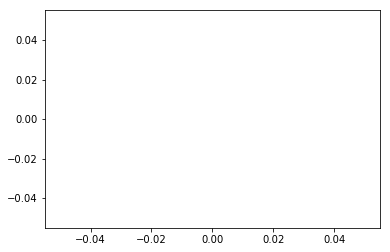

In [76]:
plt.plot(x= np.linspace(0,1,100), y=  SR_ba(np.linspace(0,1,100)))

In [77]:
SR_ba(np.linspace(0,1, 100))

array([ 0.65450425,  0.64971244,  0.64476365,  0.63972188,  0.63463875,
        0.62955557,  0.62450499,  0.61951255,  0.61459792,  0.60977598,
        0.60505773,  0.600451  ,  0.59596108,  0.59159123,  0.58734308,
        0.58321697,  0.57921227,  0.57532751,  0.57156067,  0.56790925,
        0.56437043,  0.56094114,  0.55761817,  0.55439819,  0.55127785,
        0.54825377,  0.54532259,  0.542481  ,  0.53972575,  0.53705367,
        0.53446166,  0.53194675,  0.52950602,  0.52713668,  0.52483603,
        0.52260147,  0.52043051,  0.51832075,  0.51626989,  0.51427573,
        0.51233615,  0.51044912,  0.50861271,  0.50682506,  0.50508439,
        0.50338899,  0.50173724,  0.50012758,  0.49855852,  0.49702862,
        0.49553651,  0.49408089,  0.49266051,  0.49127415,  0.48992067,
        0.48859896,  0.48730798,  0.48604669,  0.48481413,  0.48360937,
        0.48243151,  0.4812797 ,  0.48015311,  0.47905094,  0.47797245,
        0.47691689,  0.47588357,  0.47487182,  0.47388097,  0.47